In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
from helpers.graph import *
from helpers.geometry import *
from helpers.sweep import *
from helpers.util import *
from helpers.util_mp import *
import matplotlib.pyplot as plt
from tsp_solver.greedy import solve_tsp
import csv
import scipy.io as sio

%load_ext autoreload
%autoreload
%matplotlib notebook

In [2]:
width = 20
step = 50

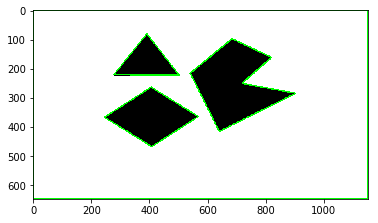

In [3]:
# img is the input image, approxes are the generated polygon
img, approxes = generate_polygon_countour("new_paint.png")
for approx in approxes:
    img = cv2.drawContours(img, [approx], 0, (0,255,0), 3)
plt.imshow(img)

In [4]:
# generate the boundary by getting the min/max value of all polygon
polygons = [np.squeeze(x) for x in approxes]

y_limit_lower = min([pt[1] for pt in polygons[0]])
y_limit_upper = max([pt[1] for pt in polygons[0]])

x_limit_lower = min([pt[0] for pt in polygons[0]])
x_limit_upper = max([pt[0] for pt in polygons[0]])

# boundary_basic certex order
boundary_basic = [[x_limit_lower, y_limit_lower], [x_limit_upper, y_limit_lower], [x_limit_upper, y_limit_upper], [x_limit_lower, y_limit_upper]]

# Among all the polygon cv2 generated, [1:] are the inner obstacles
obstacles_basic = polygons[1:]
# source_basic, dest_basic = [[10, 10], [1000, 500]]

In [5]:
boundary, sorted_vertices, obstacles = extract_vertex(boundary_basic, obstacles_basic)

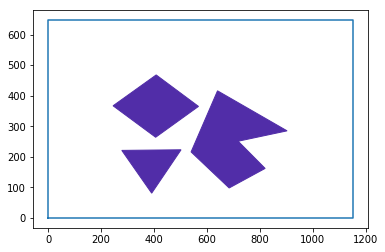

In [6]:
draw_problem(boundary, obstacles)
open_line_segments = get_vertical_line(sorted_vertices, obstacles,  y_limit_lower, y_limit_upper)

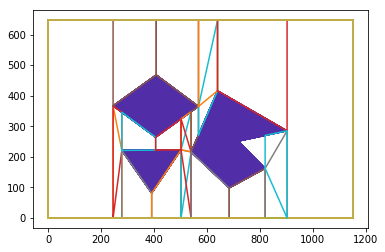

In [7]:
#------------------------------------------------------
# Find Polygon cells naiively. Will improve next. 
# open_line_segments and sorted_vertices has the same order of points, based on the x_value
quad_cells, left_tri_cells, right_tri_cells = generate_naive_polygon(open_line_segments, sorted_vertices, obstacles)
draw_cell(quad_cells, boundary, obstacles)

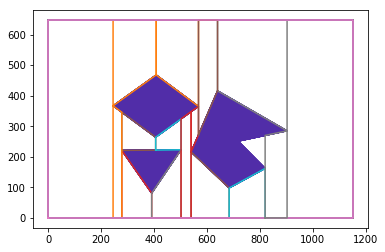

In [8]:
#-------------------------------------------------------
# Merge overlapping Polygons
refine_quad_cells(quad_cells)
draw_cell(quad_cells, boundary, obstacles)

In [9]:
# ------------------------------------------------------
# Add boundary lines
if( boundary[0].x != sorted_vertices[0].x):
    quad_cells.append([boundary[0], point(sorted_vertices[0].x, y_limit_lower), point(sorted_vertices[0].x, y_limit_upper), boundary[3]]);
if( boundary[1].x != sorted_vertices[len(sorted_vertices)-1].x):
    quad_cells.append([point(sorted_vertices[len(sorted_vertices)-1].x ,y_limit_lower), boundary[1], boundary[2], point(sorted_vertices[len(sorted_vertices)-1].x, y_limit_upper)]);


In [10]:
all_cell = quad_cells + left_tri_cells + right_tri_cells
# sort the cell based on teh x-value of the first point
################-----   IMPORTANT  -----##################
all_cell.sort(key = lambda pnt: pnt[0].x)

In [11]:
# genenrate node set, inside path with step
# nodes = generate_node_set(all_cell, width, step)

# genenrate node set, inside path without step
nodes = generate_node_set(all_cell, width, step, safeWidth=20)

## Merge the node that share the same boundary

In [12]:
# del_nodes = []
# # merge the polygon with same vertical boundary
# for curr_node in reversed(nodes):
#     print("current_node: " + str(curr_node.index))
#     if(len(curr_node.get_adjacent()) == 1):
#         ad_node = curr_node.get_adjacent()[0]
#         if (curr_node.type == 1 or curr_node.type == 2) and (ad_node.type == 1 or ad_node.type == 3):
#             if curr_node.polygon[1].y == ad_node.polygon[0].y and curr_node.polygon[2].y == ad_node.polygon[-1].y:
#                 print("adjacent_node: " + str(ad_node.index))
#                 curr_node.polygon = merge_polygon(curr_node.polygon + ad_node.polygon)
#                 curr_node.adjacent = ad_node.get_adjacent()
#                 curr_node.middle_point = ad_node.middle_point
                
#                 old_path = curr_node.path_to_adjaceny[0]
#                 curr_node.path_to_adjaceny = []
#                 for path in ad_node.path_to_adjaceny:
#                     print("path")
#                     curr_node.path_to_adjaceny.append(old_path + path)
                
#                 old_dist = curr_node.distance[0]
#                 curr_node.distance = []
#                 for dist in ad_node.distance:
#                     print("distance is " + str(dist))
#                     curr_node.distance.append(old_dist + dist)
#                 del_nodes.append(ad_node.index)

In [13]:
# print(del_nodes)
# del_nodes = sorted(del_nodes, reverse=True)
# for index in del_nodes:
#     nodes.pop(index)

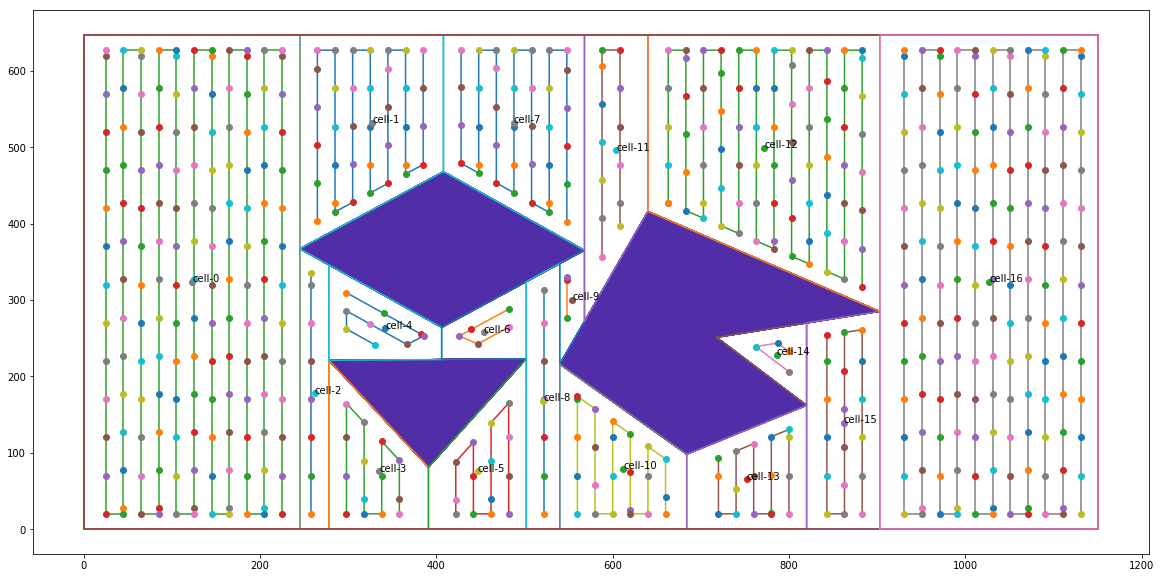

In [14]:
#-------------------------------------------------------
# Plot final cells
plt.figure(figsize=(20,10))
for index, i in enumerate(nodes):
    draw_problem(boundary, obstacles)
#     plt.figure(index)
    x = [j.x for j in i.polygon]
    x.append(x[0])
    y = [j.y for j in i.polygon]
    y.append(y[0])
    plt.plot(x, y)
    
    path_x = [pnt.x for pnt in i.inside_path]
    path_y = [pnt.y for pnt in i.inside_path]
    plt.plot(path_x, path_y)
    for pnt in i.inside_path:
        plt.plot(pnt.x, pnt.y, marker="o")
        
    center = centroid(i.polygon)
    plt.plot(center.x, center.y, marker="o")
    plt.annotate('cell-{}'.format(index), xy=(center.x, center.y))

In [15]:
# get the adjacency matrix
adjacency_matrix = get_adjacency_matrix(nodes)

In [16]:
# Dijkstra’s shortest path algorithm to get the shortest distance from the root to the target given adjacency matrix
# use each node as root node iteratively to generate the distance matrix

# generate a fully connected graph
num_node = len(nodes)
g = Graph(num_node)
g.graph = adjacency_matrix
g.generate_distance_st_matrix()

In [17]:
distance_matrix = np.array(g.distance_matrix)

In [18]:
# in order to use the solve_tsp command, we need to convert the distance matrix to a left_triangular_matrix
left_tri_matrix = []
for i in range(0, num_node):
    temp = list(np.split(distance_matrix[i], [i])[0])
    left_tri_matrix.append(temp)

In [19]:
# use the tsp package to get the shortest path to visit all the nodes
shortest_path_node = solve_tsp( left_tri_matrix, endpoints = (0, num_node-1) )
#will print path [0,1,2]
print(shortest_path_node)
# go back to the origin node 0
shortest_path_node.append(0)
print(shortest_path_node)

[0, 1, 7, 11, 12, 9, 8, 5, 3, 2, 4, 6, 10, 13, 15, 14, 16]
[0, 1, 7, 11, 12, 9, 8, 5, 3, 2, 4, 6, 10, 13, 15, 14, 16, 0]


In [20]:
st_path_matrix = g.st_path_matrix

# shortest path with step
new_path_node = generate_path_mp(shortest_path_node, st_path_matrix, nodes, step)

# shortest path without step
# new_path_node = generate_path(shortest_path_node, st_path_matrix, nodes)

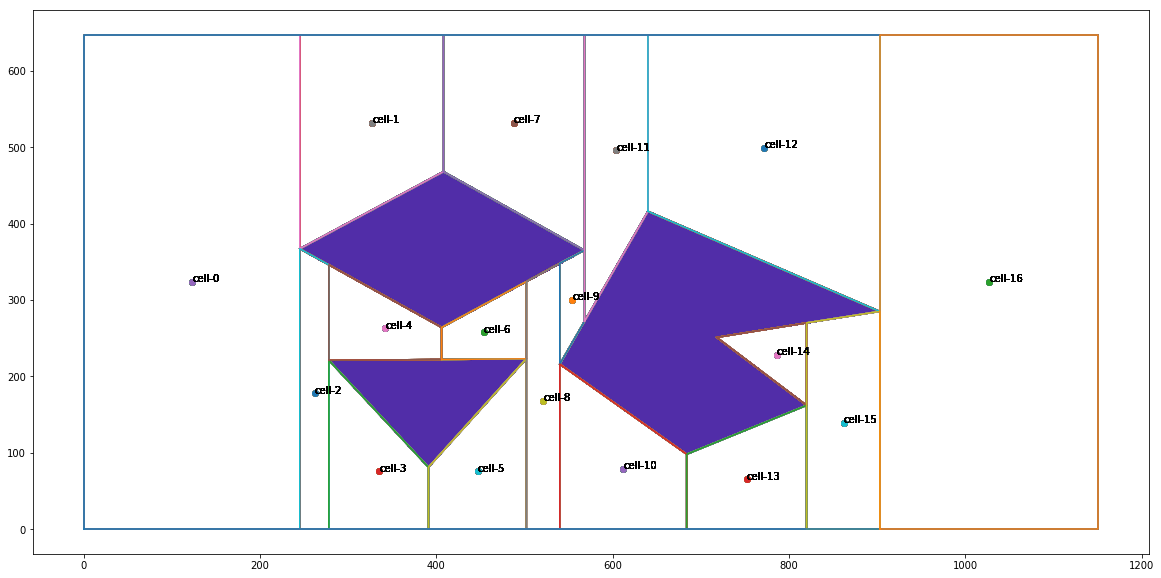

In [21]:
plt.figure(figsize=(20, 10))
for i, path in enumerate(new_path_node):
#     plt.figure(i, figsize=(20,10))
#     plt.figure(i)
    draw_node(nodes, boundary, obstacles)
    x = [pnt.x for pnt in path]
    y = [pnt.y for pnt in path]
    plt.plot(x, y)
    
    for pnt in path:
        plt.plot(pnt.x, pnt.y, marker='o')

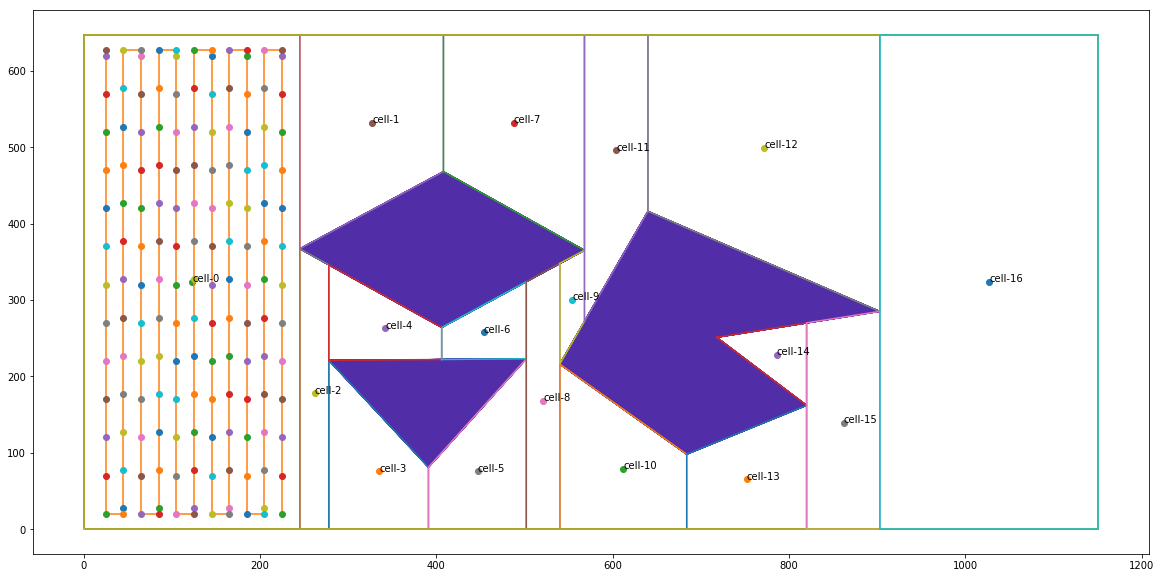

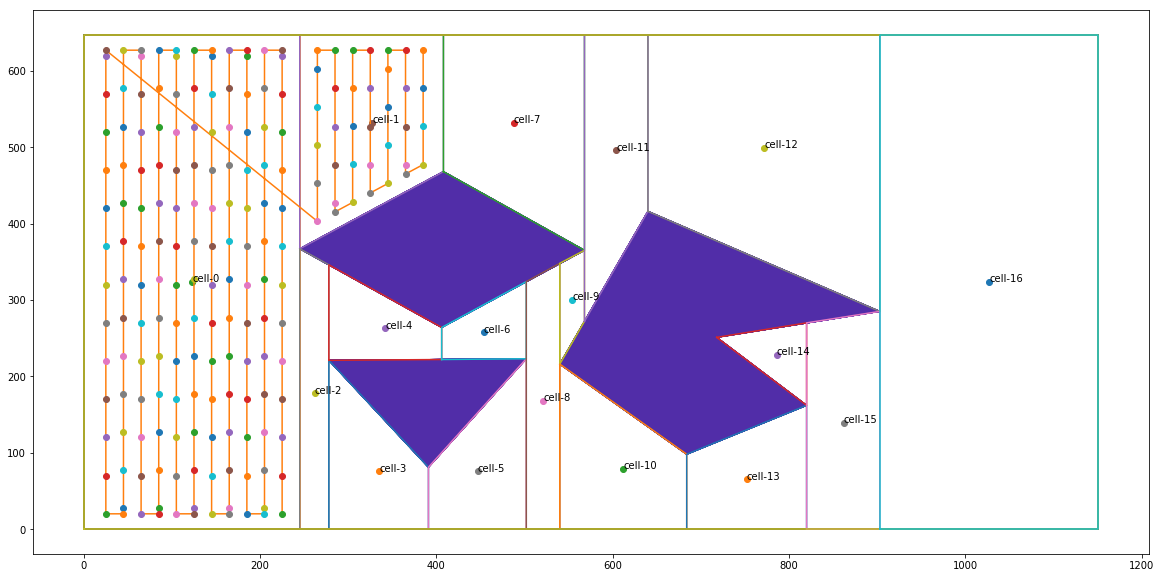

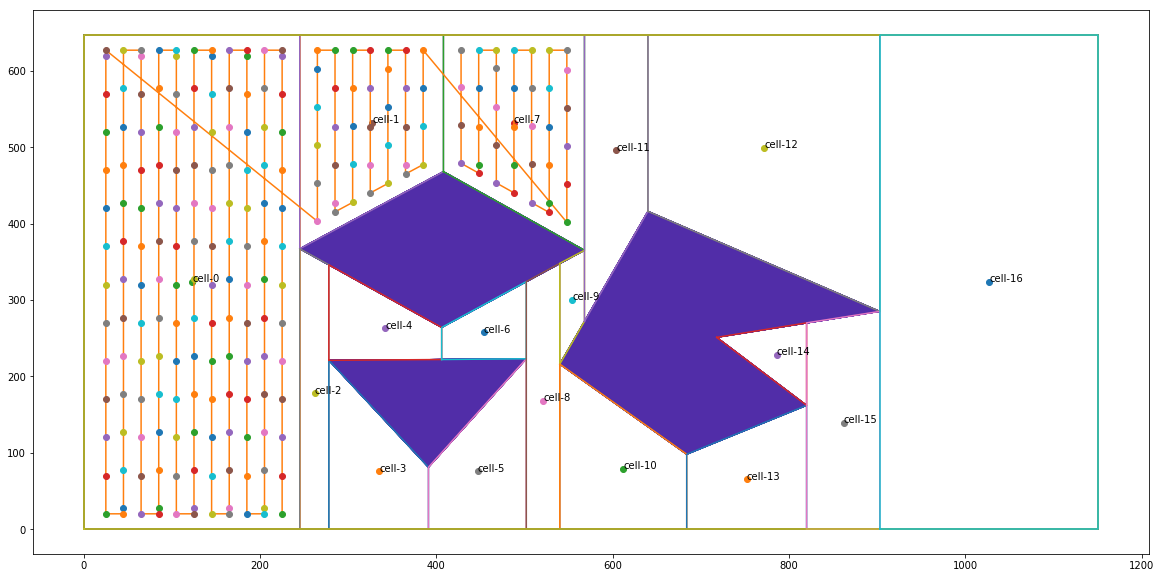

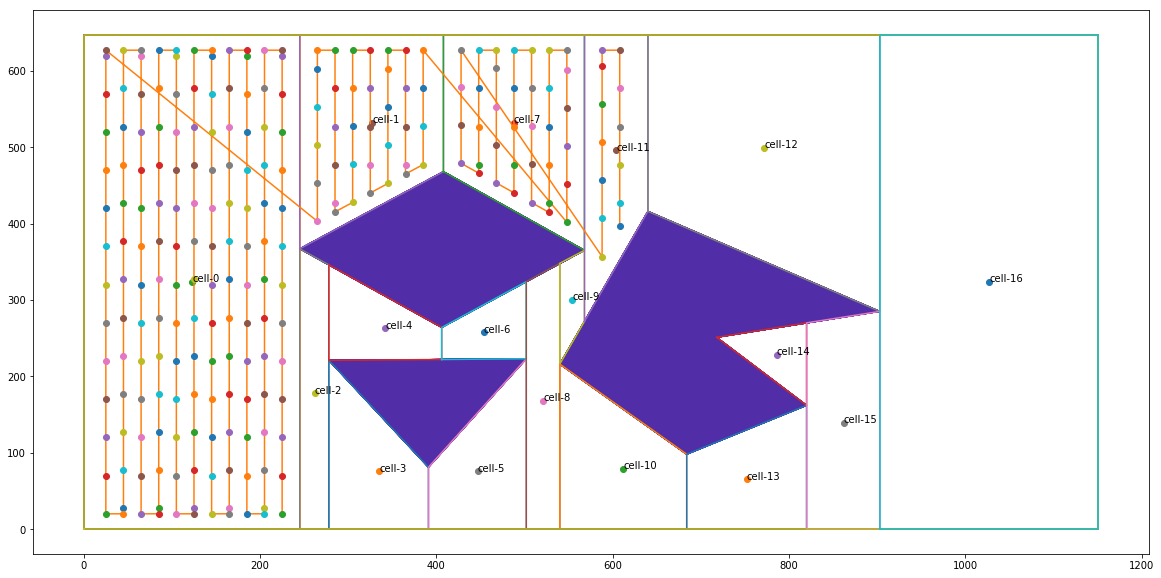

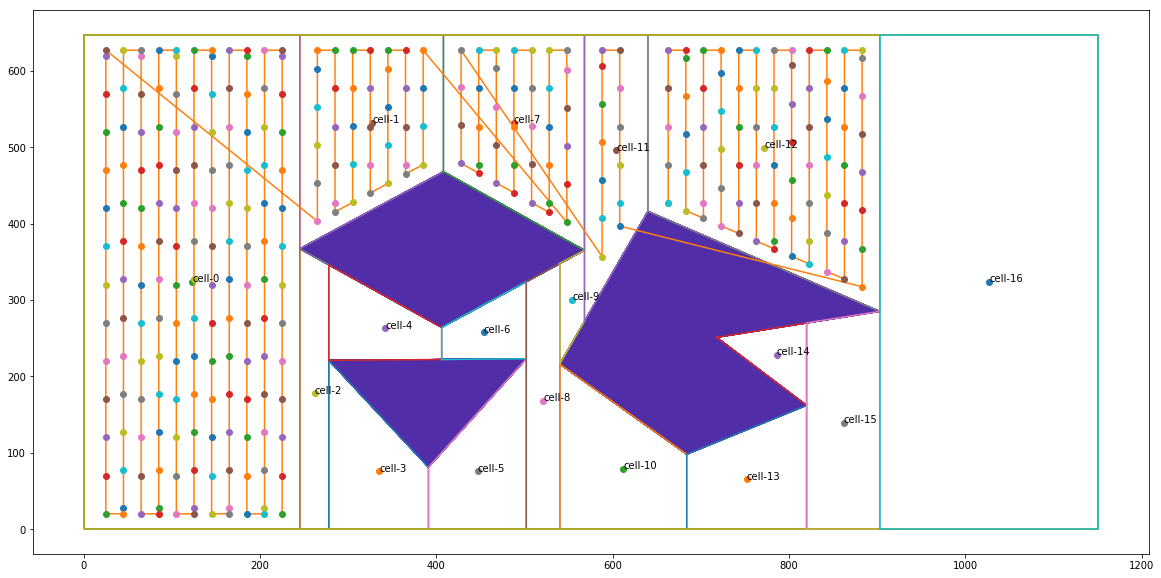

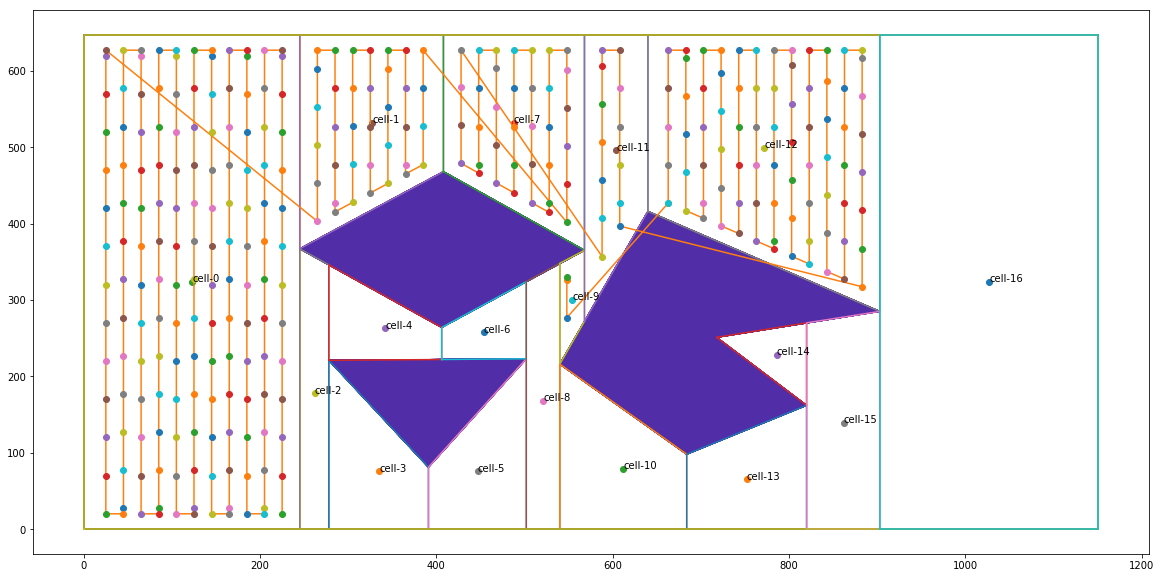

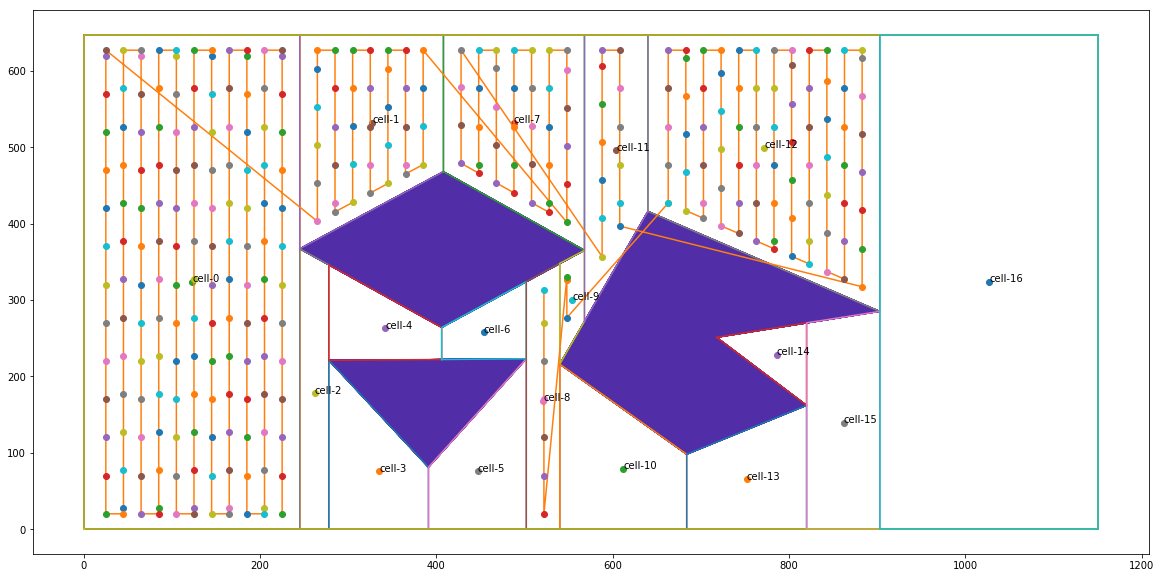

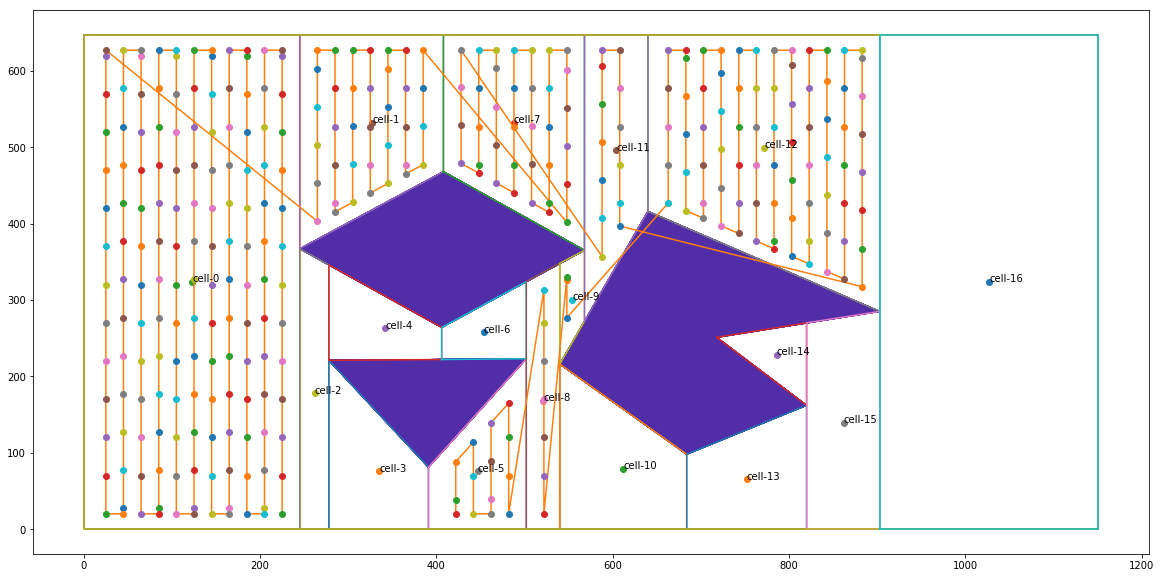

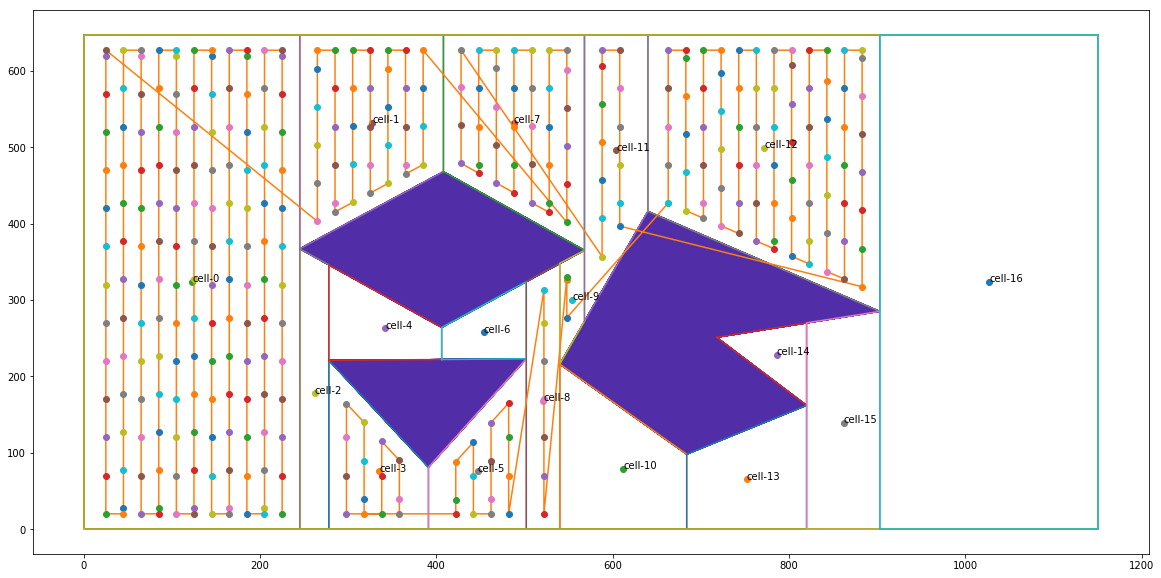

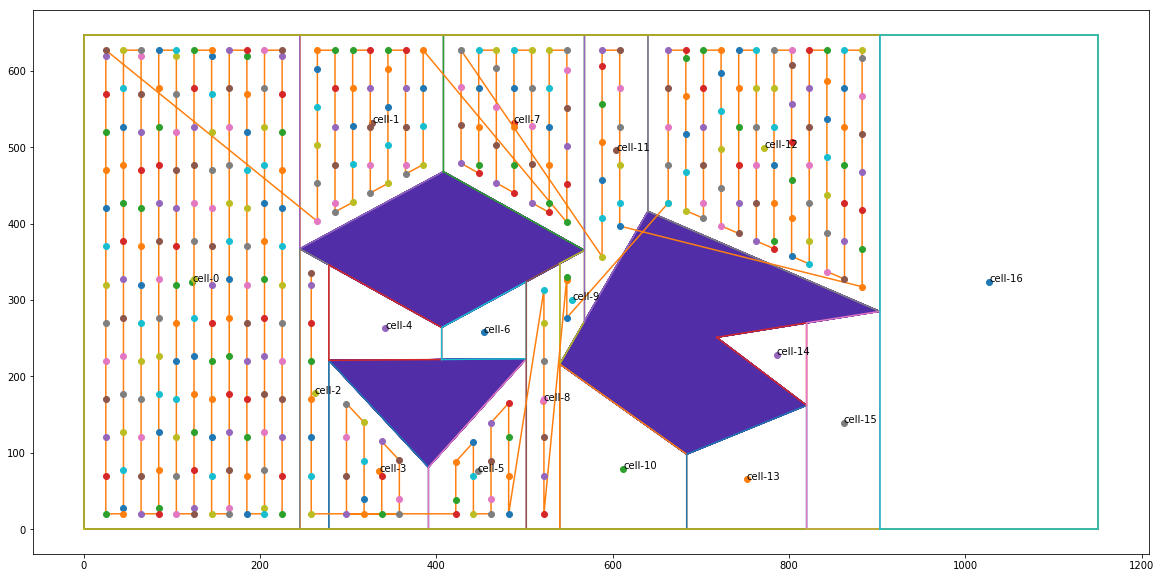

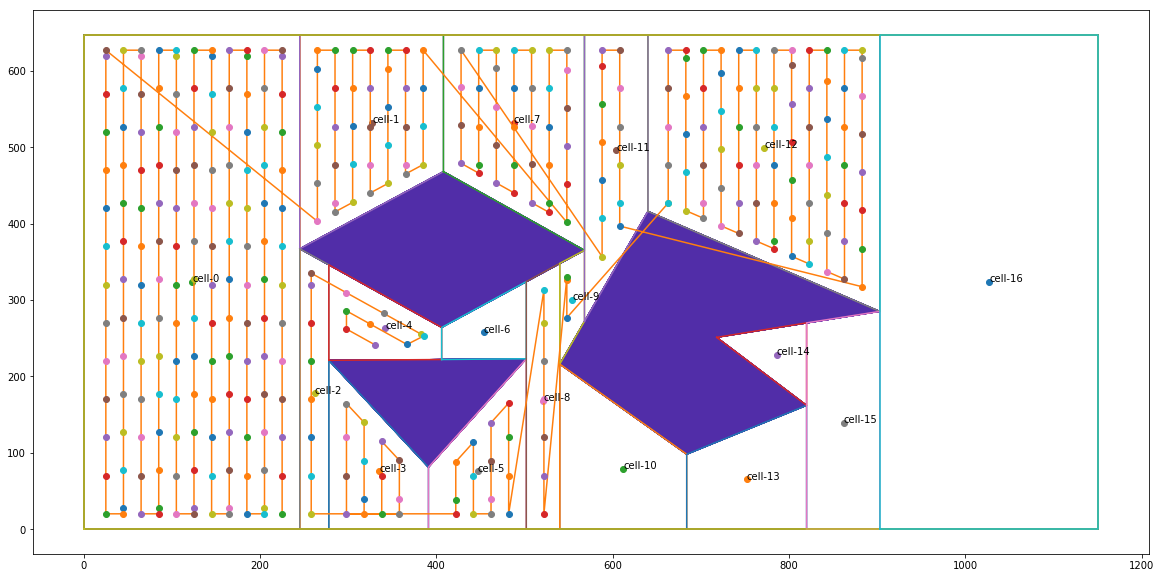

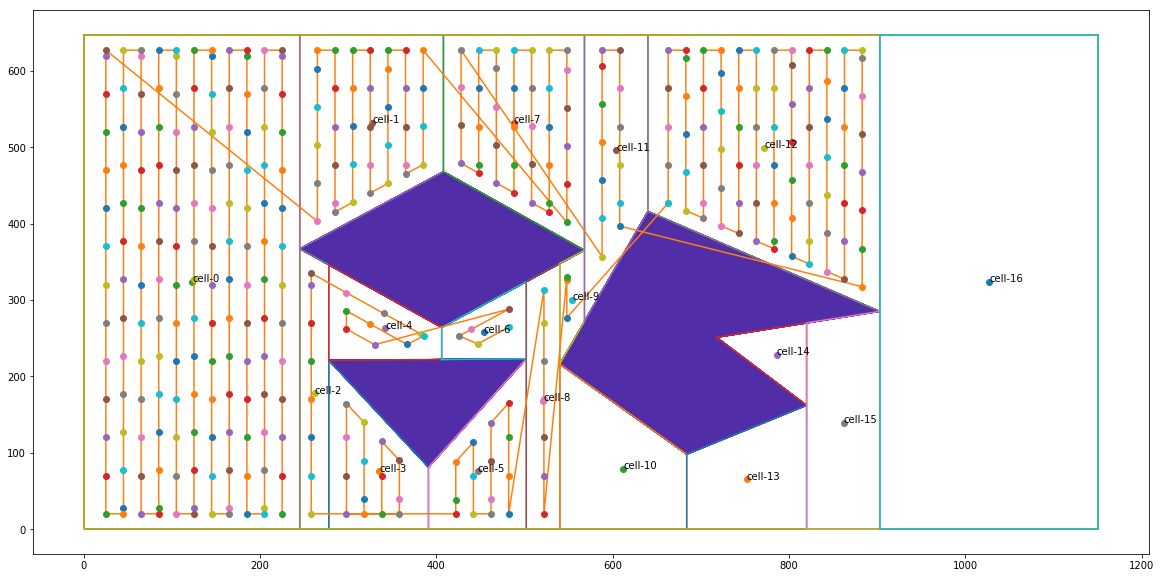

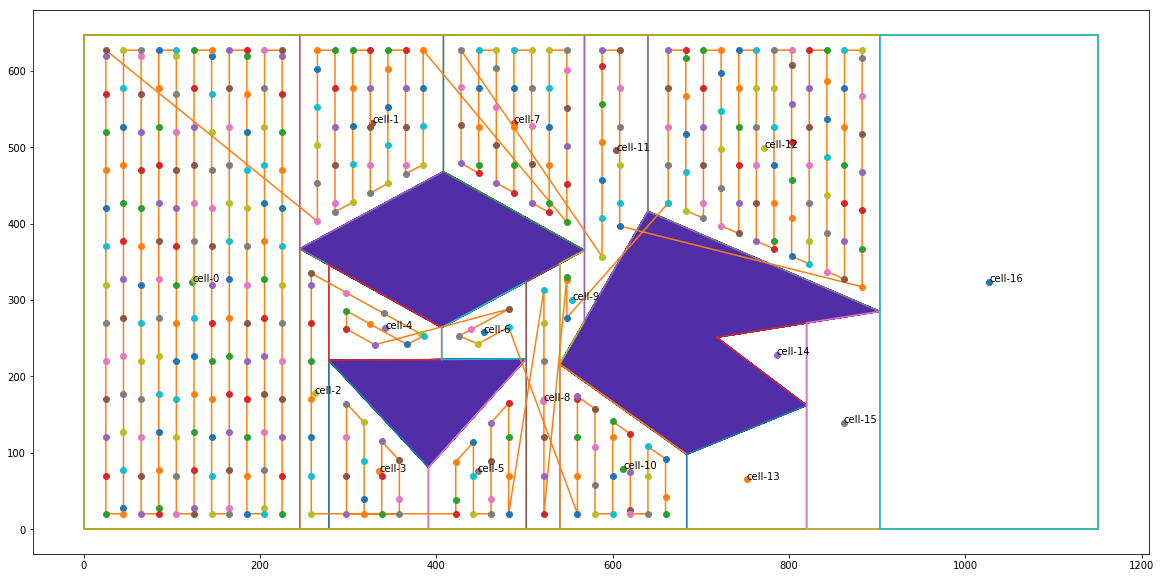

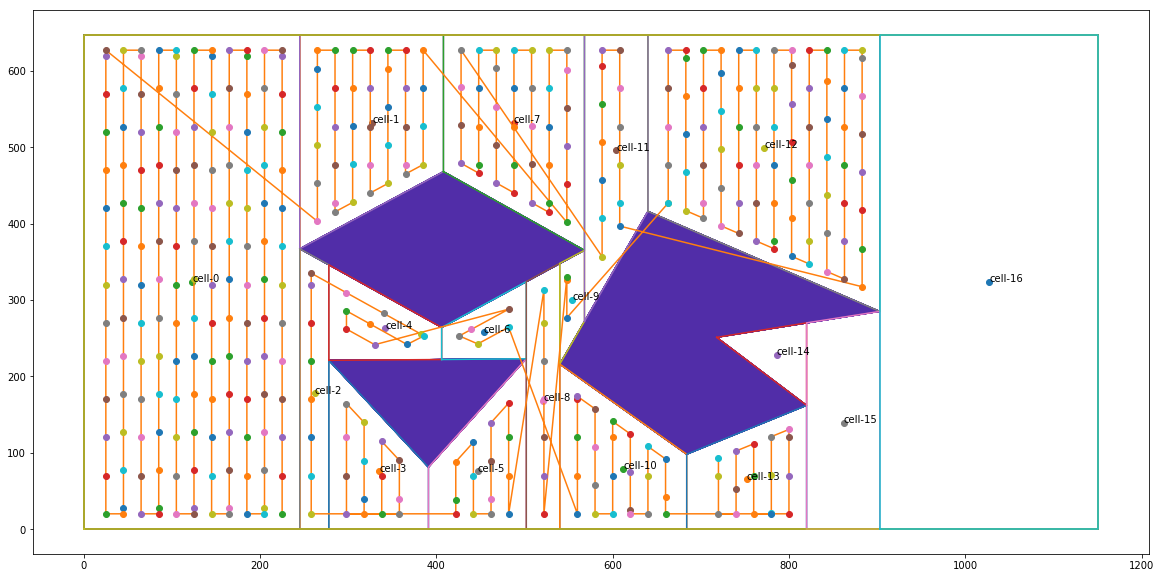

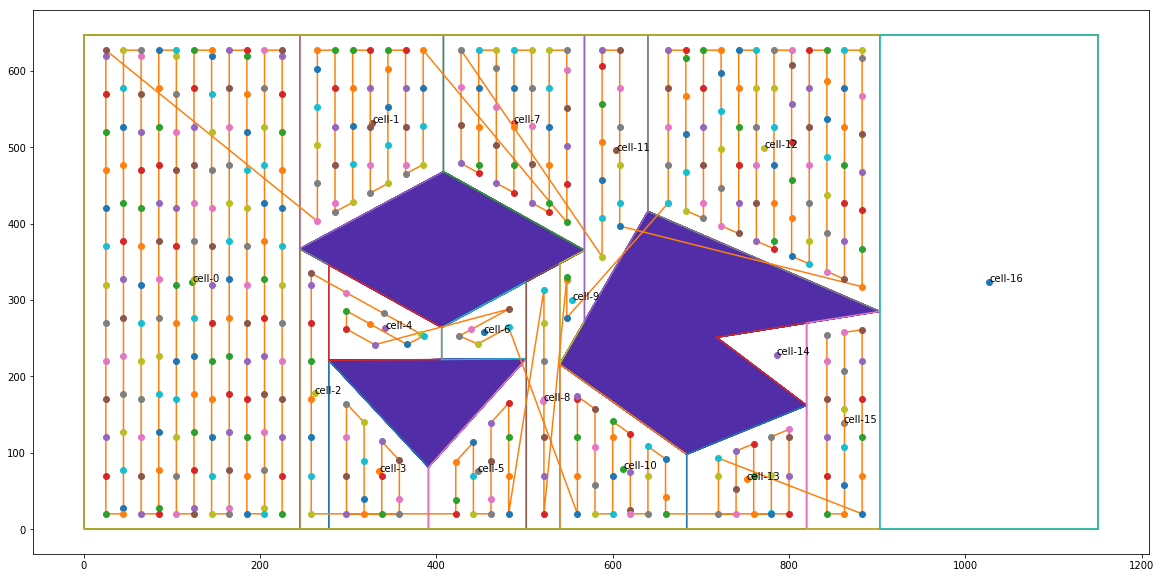

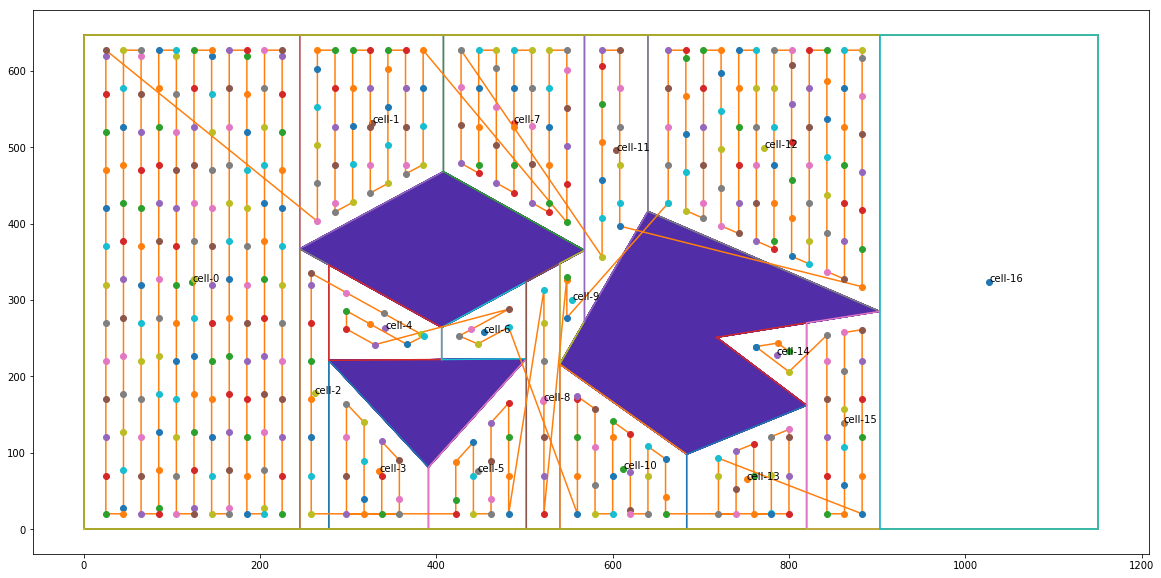

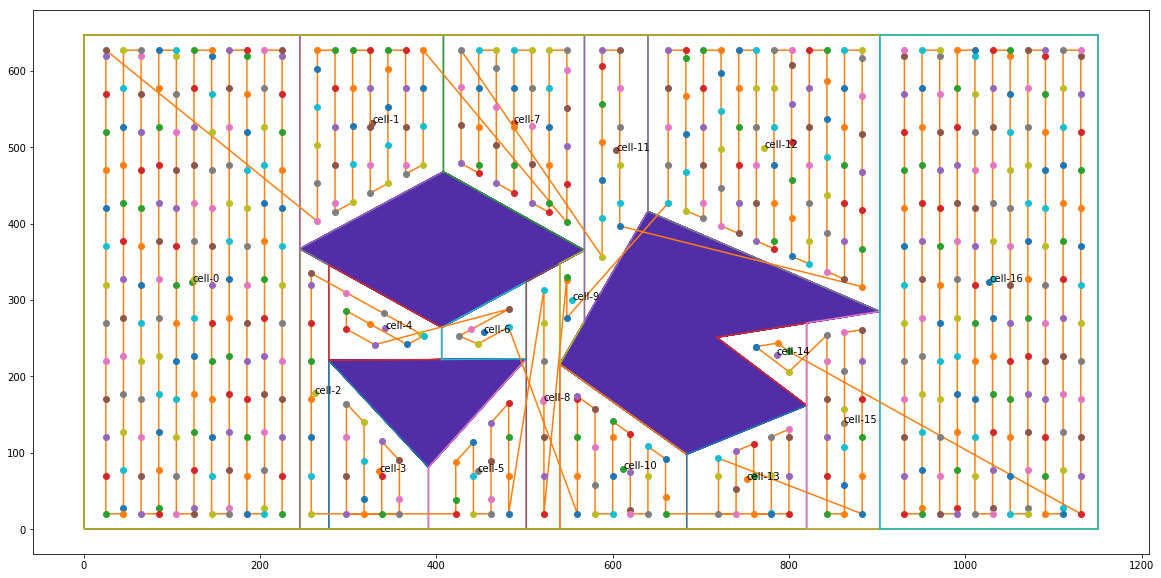

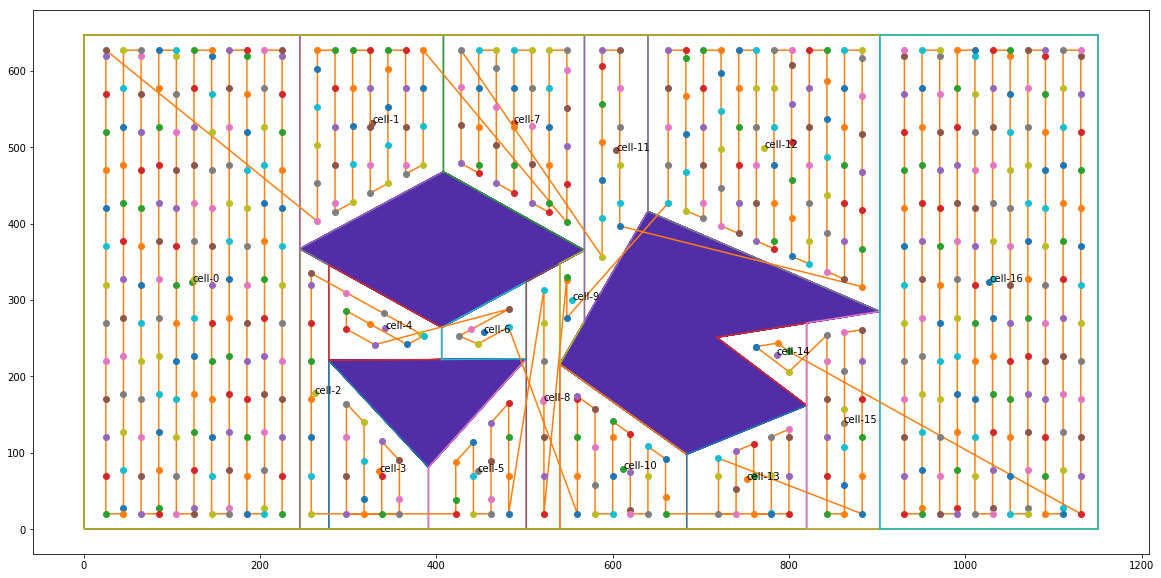

In [22]:
final_path = []
# plt.figure(figsize = (20, 10))
for i, node in enumerate(shortest_path_node):
    # go back to the origin node 0
    if(i < num_node):
        final_path = final_path + nodes[node].inside_path + new_path_node[i]    
    # stay in final node
#     if(i < num_node-1):
#         final_path = final_path + nodes[node].inside_path + new_path[i]
#     else:
#         final_path = final_path + nodes[node].inside_path
    
    plt.figure(i, figsize=(20,10))
    
    draw_node(nodes, boundary, obstacles, fill=None)
    x = [pnt.x for pnt in final_path]
    y = [pnt.y for pnt in final_path]
#     print("x-y")
#     print(x)
#     print(y)
    plt.plot(x, y)
    for pnt in final_path:
        plt.plot(pnt.x, pnt.y, marker='o')
# print(final_path)


In [23]:
list_final_path = []
list_final_path_x = []
list_final_path_y = []
for pnt in final_path:
    list_final_path.append([int(pnt.x), int(pnt.y)])
    list_final_path_x.append(int(pnt.x))
    list_final_path_y.append(int(pnt.y))

In [64]:
with open("output.csv",'w', newline='') as resultFile:
    wr = csv.writer(resultFile, delimiter=',')
    wr.writerows(list_final_path)

In [25]:
sio.savemat('output_X_Y.mat', {'X':list_final_path_x,'Y':list_final_path_y})
sio.savemat('output_XY.mat', {'XY':list_final_path})